In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    glucose_levels = []
    basal_insulin = []
    bolus_insulin = []
    carbs = []
    timestamps = []

    # Extract glucose levels
    for glucose_event in root.findall(".//glucose_level/event"):
        ts = glucose_event.get('ts')
        value = float(glucose_event.get('value'))
        glucose_levels.append((ts, value))

    # Extract basal insulin
    for basal_event in root.findall(".//basal/event"):
        ts = basal_event.get('ts')
        value = float(basal_event.get('value'))
        basal_insulin.append((ts, value))

    # Extract bolus insulin
    for bolus_event in root.findall(".//bolus/event"):
        ts = bolus_event.get('ts_begin')
        dose = float(bolus_event.get('dose'))
        bolus_insulin.append((ts, dose))

    # Extract meal data
    for meal_event in root.findall(".//meal/event"):
        ts = meal_event.get('ts')
        carbs_value = float(meal_event.get('carbs'))
        carbs.append((ts, carbs_value))

    # Combine all data into a DataFrame
    data = []
    for ts, glucose in glucose_levels:
        basal = next((value for t, value in basal_insulin if t == ts), 0)
        bolus = next((dose for t, dose in bolus_insulin if t == ts), 0)
        meal = next((carbs_value for t, carbs_value in carbs if t == ts), 0)
        data.append((ts, glucose, basal, bolus, meal))

    df = pd.DataFrame(data, columns=['timestamp', 'glucose', 'basal_insulin', 'bolus_insulin', 'carbs'])
    
    # Specify the correct format for parsing the timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M:%S')
    
    return df


In [3]:
training_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/540-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/544-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/552-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/567-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/584-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/596-ws-training.xml'
]

# Paths to testing XML files
testing_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/540-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/544-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/552-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/567-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/584-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/596-ws-testing.xml'
]

# Load and preprocess training data
training_data = [parse_xml(file) for file in training_files]
training_df = pd.concat([data for data in training_data])

# Load and preprocess testing data
testing_data = [parse_xml(file) for file in testing_files]
testing_df = pd.concat([data for data in testing_data])

# Scaling glucose levels and other relevant features
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features: glucose, basal insulin, bolus insulin, carbs
training_features = training_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values
testing_features = testing_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values

training_scaled = scaler.fit_transform(training_features)
testing_scaled = scaler.transform(testing_features)


In [4]:
def create_sequences(data, time_steps=10,horizon=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # All features except glucose
        y.append(data[i+time_steps-1, 0])  # Glucose value as the target
    return np.array(X), np.array(y)



In [5]:
def compute_time_gain(Ts, PH, y_true, y_pred):
    """
    Compute the Time Gain (TG) for glucose level prediction in T1DM.

    Parameters:
    Ts (float): Sampling time
    PH (int): Prediction horizon
    y_true (numpy array): True glucose levels
    y_pred (numpy array): Predicted glucose levels

    Returns:
    TG (numpy array): Time Gain values
    """
    TG = np.zeros(PH)
    for i in range(PH):
        delay = np.abs(y_true[i] - y_pred[i])
        TG[i] = (i + 1) * Ts - delay
    return TG

In [19]:
horizons = [30, 45, 60]

# TCN Model
# Function to build TCN model
def build_tcn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))  # Output layer for glucose prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model




Training model for 30-minute horizon
Epoch 1/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0038 - val_loss: 9.4049e-05
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.7569e-05 - val_loss: 6.5995e-05
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.3038e-05 - val_loss: 4.8603e-05
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.0148e-05 - val_loss: 8.1998e-05
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.4213e-05 - val_loss: 2.6629e-05
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.3596e-05 - val_loss: 1.9616e-05
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.9990e-05 - val_loss: 1.3479e-04
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.2286e-05 - val_loss: 2.0882e-05
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.8297e-05 - val_loss: 3.4770e-05
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.3582e-05 - val_loss: 1.5731e-05
493/49

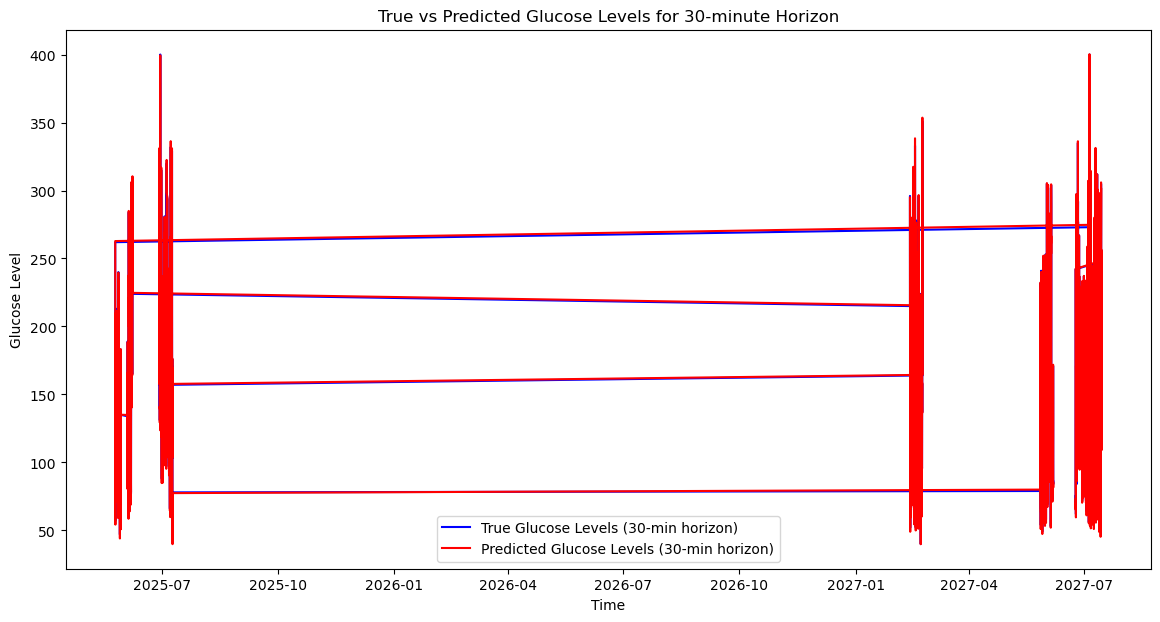

Root Mean Squared Error (RMSE): 1.4278409160126573
Time Gain (TG): [  4.81038642   9.67778921  14.98610568  19.67640018  24.51499939
  28.01315975  33.38521957  39.77565384  43.07159519  48.46627402
  53.69943857  59.94424391  64.7178843   69.77975655  74.582932
  79.75683308  84.14090681  89.36774135  94.9354229   99.57342672
 104.1721549  109.65299988 114.62473512 119.7786448  124.39689112
 128.82801485 133.77188158 138.8643508  144.77684093 148.84688663]
Training model for 45-minute horizon
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0049 - val_loss: 5.0434e-05
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.5177e-05 - val_loss: 3.4643e-05
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.1343e-05 - val_loss: 3.2813e-05
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.6747e-05 - val_loss: 2.5498e-05
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.0199e-05 - val_loss: 1.6551e-05
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.3413e-05 - val_loss: 4.0600e-05
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.4922e-05 - val_loss: 1.3450e-05
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.9403e-05 - val_loss: 1.7923e-05
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.8706e-05 - val_loss: 1.5624e-05
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.3235e-05 - val_loss: 2.6358e-05
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step


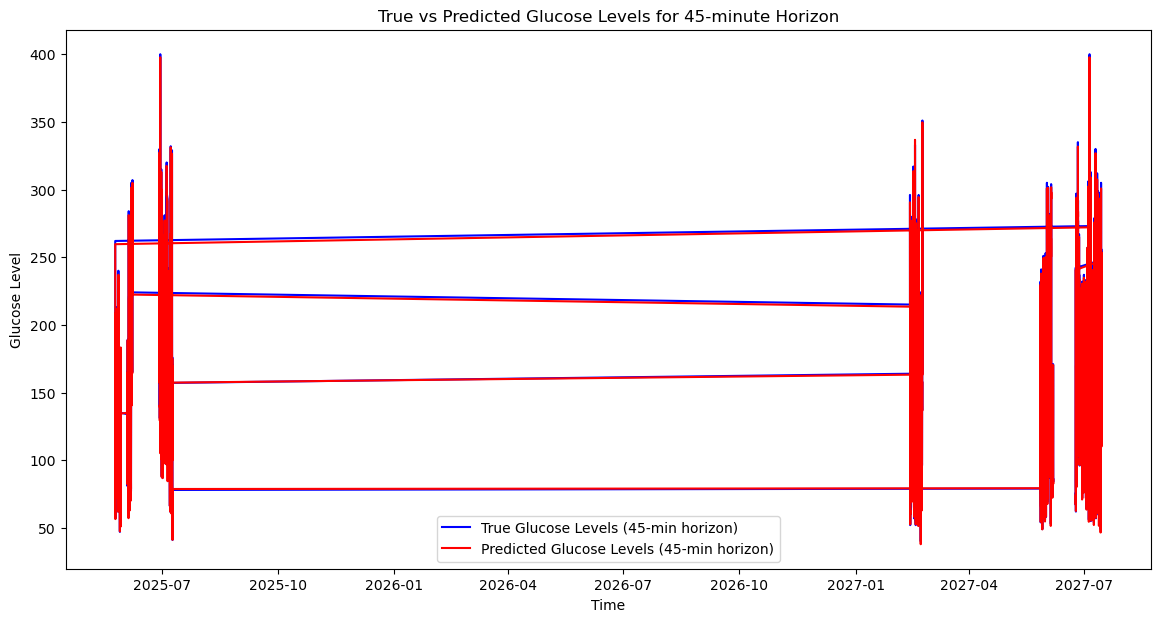

Root Mean Squared Error (RMSE): 1.848232829196986
Time Gain (TG): [  2.47868347   7.7814889   13.71189642  18.75071621  24.23689365
  26.5516777   31.51080608  39.72622776  44.12233448  49.6913166
  53.05744648  59.44850731  63.72753763  69.78222799  74.06672478
  79.08520794  83.6122756   89.22398567  94.73138189  99.46751165
 104.23996115 109.792346   114.2376709  119.68033218 124.99677944
 128.28062963 133.08914137 139.21265173 143.77855492 148.56679964]
Training model for 60-minute horizon
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023 - val_loss: 8.4204e-05
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1577e-04 - val_loss: 5.0537e-05
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.6570e-05 - val_loss: 3.9755e-05
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.0150e-05 - val_loss: 6.5442e-05
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.7433e-05 - val_loss: 4.1356e-05
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.5356e-05 - val_loss: 5.9082e-05
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.2000e-05 - val_loss: 8.6945e-05
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.0412e-05 - val_loss: 1.4759e-05
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.7948e-05 - val_loss: 1.0838e-05
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.0594e-05 - val_loss: 4.7879e-05
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step


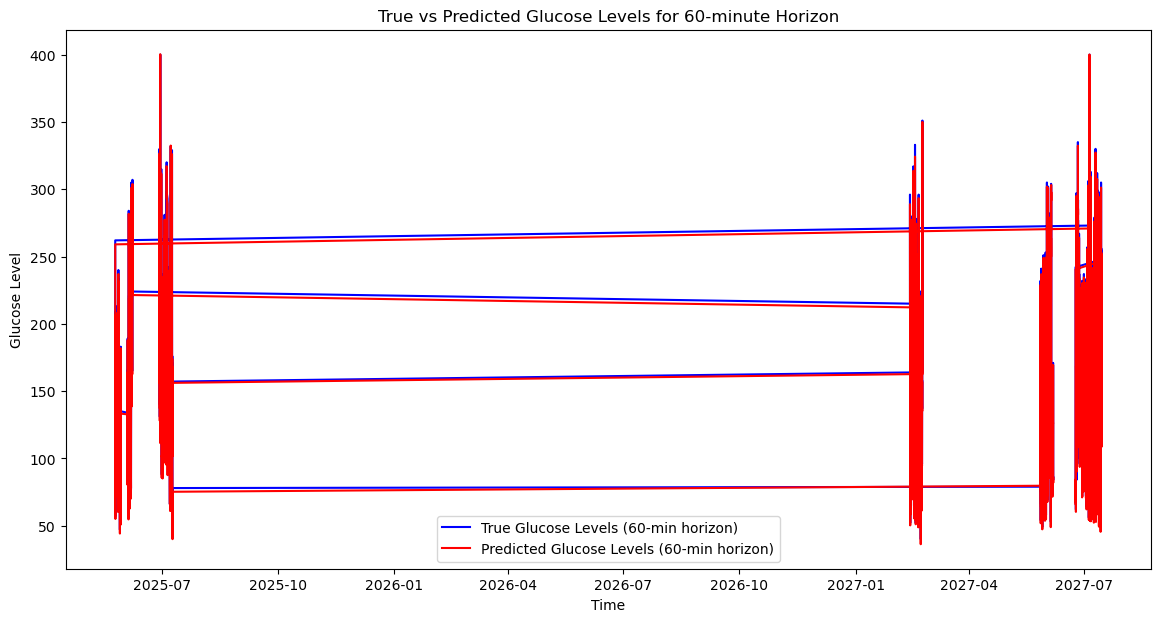

Root Mean Squared Error (RMSE): 2.49100351275385
Time Gain (TG): [  1.34923744   6.7027688   12.54459906  17.05463743  22.84657598
  25.44199419  30.78921676  37.62792492  44.62129736  48.73595667
  51.52959585  57.8010087   62.01570892  67.81769228  72.27665067
  77.54312015  82.02962208  87.50112772  92.87488556  97.65284705
 102.50626707 108.54895449 112.75408745 118.43259001 124.25157595
 126.89137411 132.17826319 137.80412722 142.74771762 146.90947342]


In [20]:
horizons=[30,45,60]
for horizon in horizons:
    print(f"Training model for {horizon}-minute horizon")
    # Create sequences for training and testing data
    X_train, y_train = create_sequences(training_scaled, time_steps=10, horizon=horizon)
    X_test, y_test = create_sequences(testing_scaled, time_steps=10, horizon=horizon)

        # Build and train the TCN model
    model = build_tcn_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # Make predictions
    predictions = model.predict(X_test)
        # Rescale predictions and actual values back to original scale
    predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 3))], axis=-1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))], axis=-1))[:, 0]

        # Plot true vs predicted glucose levels
    plt.figure(figsize=(14, 7))
    plt.plot(testing_df['timestamp'][len(testing_df) - len(y_test_rescaled):], y_test_rescaled, label=f'True Glucose Levels ({horizon}-min horizon)', color='blue')
    plt.plot(testing_df['timestamp'][len(testing_df) - len(predictions_rescaled):], predictions_rescaled, label=f'Predicted Glucose Levels ({horizon}-min horizon)', color='red')
    plt.xlabel('Time')

    plt.ylabel('Glucose Level')
    plt.title(f'True vs Predicted Glucose Levels for {horizon}-minute Horizon')
    plt.legend()
    plt.show()

        # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

        # Compute time gain (replace with actual implementation)
    TG = compute_time_gain(5, 30, y_test_rescaled, predictions_rescaled)
    print(f"Time Gain (TG): {TG}")
